In [1]:
import serial
import time
import re
import pandas as pd
import numpy as np
import pickle
import json

from IPython.display import IFrame
import serial.tools.list_ports

import pickle
import numpy as np
from pyargus.directionEstimation import *

import math
from collections import deque
from scipy.spatial import distance

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
from matplotlib.collections import PatchCollection

import matplotlib.colors as mcolors
import pydbus
from time import sleep
import matplotlib
import colorsys

In [17]:
class Candidate():
    
    def __init__(self, spacing, degree_diff, iot_locations):
        super(Candidate, self).__init__()

        self.width = [0,7]
        self.height = [0,5.4]
        self.spacing = spacing
        self.degree_diff = degree_diff
              
        self.x_range = np.arange(self.width[0], self.width[1], self.spacing)
        self.y_range = np.arange(self.height[0], self.height[1], self.spacing)
    
        self.iot_locations = iot_locations
        
    def search_insert_position(self, nums, target):
        left = 0
        right = len(nums) - 1
        
        while left <= right:
            mid = (left + right) // 2
            
            if nums[mid] == target:
                return mid
            elif target > nums[mid]:
                left = mid + 1
            else:
                right = mid - 1
        
        return right
    
    
    def get_coord(self, x, y):
        
        if x>self.width[1] or x<self.width[0] or y>self.height[1] or y<self.height[0]:
            return
        
        rect_x = self.search_insert_position(self.x_range, x)
        rect_y = self.search_insert_position(self.y_range, y)   

        return rect_x, rect_y
    
    
    def scale_lightness(self, rgb, scale_l):
        h, l, s = colorsys.rgb_to_hls(*rgb)
        return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)


    def get_candidate(self, index, coord, degree_adjust):
        
        if index in [2,6]:
            degrees = np.arange(67.5, 90, self.degree_diff)
        elif index in [1,3,5,7]:
            degrees = np.arange(22.5, 67.5, self.degree_diff)
        elif index in [4,8]:
            degrees = np.arange(0, 22.5, self.degree_diff)

        candidates = [self.get_coord(coord[0], coord[1])]    
            
        pm = np.array([+1, -1])

        for degree in degrees:
            d = self.spacing
            while True:
                x1, x2 = coord[0] + pm*(d/np.sqrt(1+ math.tan(degree * (math.pi/180))**2))
                y1, y2 =coord[1] + pm*((d*math.tan(degree *(math.pi/180)))/np.sqrt(1+ math.tan(degree * (math.pi/180))**2))

                if (x1>self.width[1] and x2<self.width[0]) or (y1>self.height[1] and y2<self.height[0]):                                  
                    break
                
                if index == 1:
                    candidates.append(self.get_coord(x1, y1))
                elif index == 2:
                    candidates.append(self.get_coord(x1, y1))
                    candidates.append(self.get_coord(x2, y1))
                elif index==3:
                    candidates.append(self.get_coord(x2, y1))
                elif index == 4:
                    candidates.append(self.get_coord(x2, y1))
                    candidates.append(self.get_coord(x2, y2))
                elif index==5:
                    candidates.append(self.get_coord(x2, y2))
                elif index == 6:
                    candidates.append(self.get_coord(x1, y2))
                    candidates.append(self.get_coord(x2, y2))
                elif index==7:
                    candidates.append(self.get_coord(x1, y2))
                elif index == 8:
                    candidates.append(self.get_coord(x1, y1))
                    candidates.append(self.get_coord(x1, y2))
         
                d += self.spacing 
            
        candidates =  [*set(candidates)] #remove duplicates
        candidates = list(filter(lambda item: item is not None, candidates)) #remove null
        
        return candidates
    
    
    def visualize(self, candidates):
        plt.figure(figsize=(6, 4)) 
        ax = plt.axes()
        
        for i in self.x_range:
            plt.axvline(x = i, color = '#7c7f83', linewidth=0.1)
        
        for i in self.y_range:
            plt.axhline(y = i, color = '#7c7f83', linewidth=0.1)
            
        rects = []
        for key in list(self.iot_locations.keys()):
            rect = Rectangle((iot_locations[key][0], iot_locations[key][1]), self.spacing, self.spacing, 
                             color="blue", alpha=1)
            
            rects.append(rect)
        
        scales = np.arange(0.2,1.7, 1.5/(len(candidates) + len(self.iot_locations)))
        color = matplotlib.colors.ColorConverter.to_rgb("red")
        rgbs = [self.scale_lightness(color, scale) for scale in scales]

        i=0
        for x,y in candidates:
            rect = Rectangle((self.x_range[x], self.y_range[y]), self.spacing, self.spacing, 
                             color=(rgbs[i]), alpha=0.6)
            rects.append(rect)
            i+=1

        ax.add_collection(PatchCollection(rects, match_original=True))

        plt.gca().invert_xaxis()
        
        plt.xlim(self.width)
        plt.ylim(self.height)
        
        clear_output(wait=True)
        plt.show()
        
    def sort_candidates(self, candidates, direction):
        if direction == 1:
            candidates.sort(key=lambda x: x[1] - x[0]*math.tan((180-22.5)*(math.pi/180)))
        elif direction == 2:
            candidates.sort(key=lambda x: x[1])
        elif direction == 3:
            candidates.sort(key=lambda x: x[1] - x[0]*math.tan(22.5*(math.pi/180)))
        elif direction == 4:
            candidates.sort(key=lambda x: -x[0]) 
        elif direction == 5:
            candidates.sort(key=lambda x: -(x[1] - x[0]*math.tan((180-22.5)*(math.pi/180)))) 
        elif direction == 6:
            candidates.sort(key=lambda x: -x[1])
        elif direction == 7:
            candidates.sort(key=lambda x: -(x[1] - x[0]*math.tan(22.5*(math.pi/180)))) 
        elif direction == 8:
            candidates.sort(key=lambda x: x[0]) 
        
        return candidates

In [18]:
%run ../featurizer.ipynb
%run ../location.ipynb
%run ../direction.ipynb
%run ../utils.ipynb

f = Featurizer()
f.set_utils(location_id='Arena', user_id='user_01')

spacing = 0.2
degree_diff = 0.3
iot_locations = {"light 1": (3.9,2.35),
                 "light 2": (1.35,2.3),
                 "light 3": (1.38, 3.25)
                }

c = Candidate(spacing, degree_diff, iot_locations)

reference = {'W': 2, 
             'SW': 3, 
             'S': 4, 
             'SE': 5, 
             'E': 6, 
             'NE': 7, 
             'N': 8, 
             'NW':1
            }

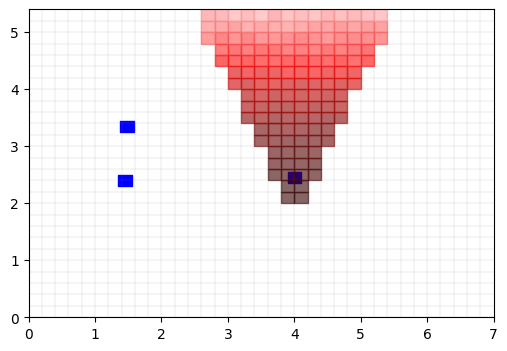

In [19]:
spacing = .2
degree_diff = 0.2
degree_adjust = 0

c = Candidate(spacing, degree_diff, iot_locations)

direction = 2
coords = [4, 2]
candidates = c.get_candidate(direction,coords, degree_adjust)
candidates = c.sort_candidates(candidates, direction)
c.visualize(candidates)

# for i in range(1):
#     for direction in range(1,9):
#         coords = [2+i, 2+i]
#         candidates = c.get_candidate(direction,coords)
#         candidates = c.sort_candidates(candidates, direction)
#         c.visualize(candidates)

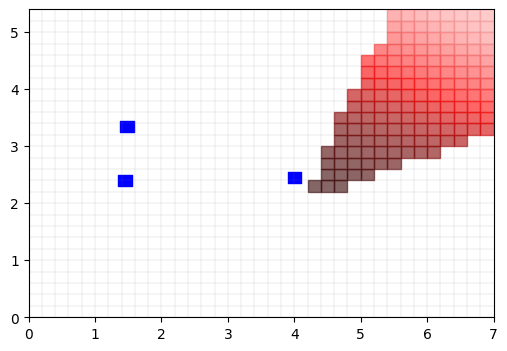

In [ ]:
while True:
    direction = f.get_direction()
    direction = reference[direction.values[0][0]]
    coords = f.get_location()
    coords = coords.loc[0, :].values.tolist()
    candidates = c.get_candidate(direction, coords[0:2])
    candidates = c.sort_candidates(candidates, direction)

    c.visualize(candidates)
    